У нас есть некоторая функция (даже не обязательно распределение) $p(x)$ из соответствующего распределения $\frac{p(x)}{\int_{-\infty}^{\infty} p(x) dx}$ которой мы хотим сэмплировать точки

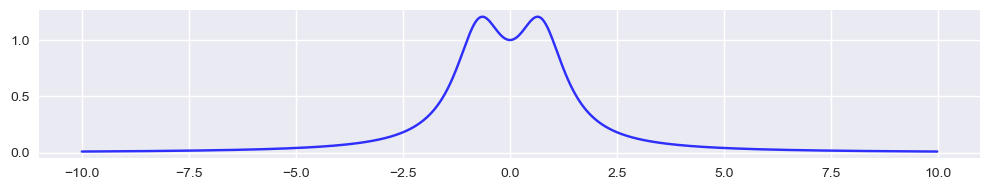

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8')

p = lambda x: (1 + x**2) / (1 + x**4)
x = np.linspace(-10, 10, num=1000, endpoint=False)

plt.figure(figsize=(10, 2), dpi=100)
plt.plot(x, p(x), 'b-', label=f'Целевая функция', alpha=0.8)
plt.tight_layout()

Еще у нас есть распределение $q(x)$ из которого мы умеем сэмплировать 

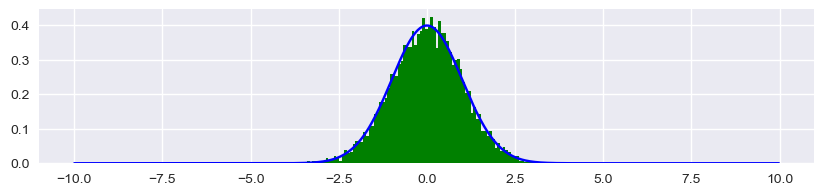

In [2]:
sigma2 = np.sqrt(1)

def sample_q(x):
    return np.random.normal(x, scale=sigma2)

q = lambda x: np.exp(-x**2 / 2 * sigma2) / np.sqrt(2 * np.pi * sigma2)
hist = [sample_q(0) for _ in range(10000)]

plt.figure(figsize=(10, 2), dpi=100)
plt.hist(hist, bins=100, density=True, color='green')
plt.plot(x, q(x), 'b-')

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_19928\948701918.py:5: RuntimeWarning: invalid value encountered in scalar divide
  alpha = min(1, p(next) / p(prev) * q(sample_q(prev)) / q(sample_q(next)))
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_19928\948701918.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(1, p(next) / p(prev) * q(sample_q(prev)) / q(sample_q(next)))


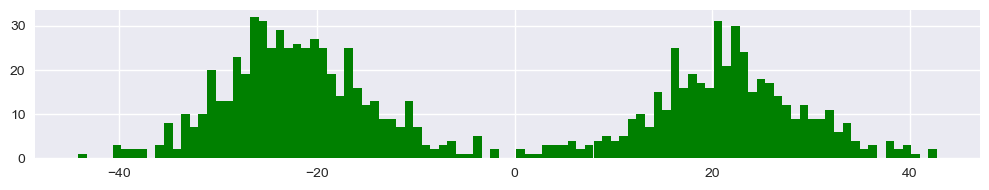

In [4]:
def sample_p(init, p, sample_q, steps):
    prev = init
    for i in range(steps):
        next = sample_q(prev)
        alpha = min(1, p(next) / p(prev) * q(sample_q(prev)) / q(sample_q(next)))
        accept = np.random.binomial(1, alpha)
        if accept:
            prev = next
    return next


hist = [sample_p(0, p, sample_q, 100) for _ in range(1000)]

plt.figure(figsize=(10, 2), dpi=100)
plt.hist(hist, bins=100, color='green')
plt.tight_layout()

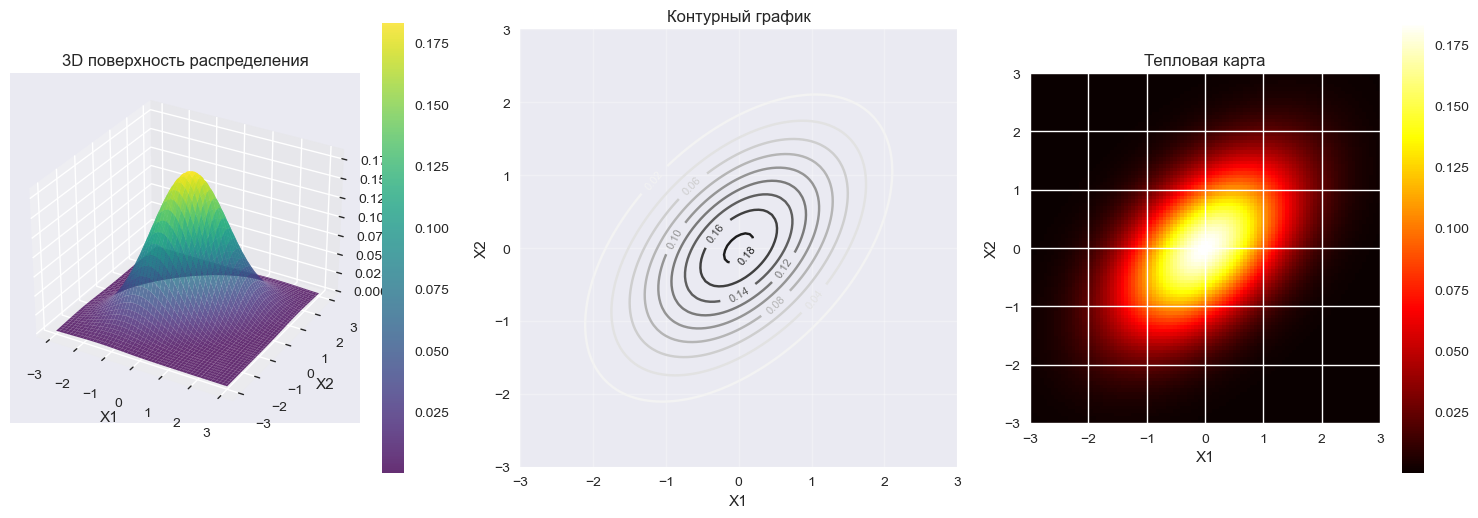

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

def simple_2d_normal(x, mu=np.array([0, 0]), Sigma=np.array([[1, 0.5], [0.5, 1]])):
    """
    Простое двумерное нормальное распределение
    """
    k = len(mu)
    x = np.array(x)
    mu = np.array(mu)
    
    # Вычисляем многомерную нормальную плотность
    det_Sigma = np.linalg.det(Sigma)
    inv_Sigma = np.linalg.inv(Sigma)
    
    exponent = -0.5 * (x - mu).T @ inv_Sigma @ (x - mu)
    normalization = 1 / ((2 * np.pi) ** (k/2) * np.sqrt(det_Sigma))
    
    return normalization * np.exp(exponent)

# Визуализация двумерного нормального распределения
def plot_2d_normal():
    # Создаем сетку для визуализации
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    # Вычисляем плотность в каждой точке сетки
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = simple_2d_normal([X[i, j], Y[i, j]])
    
    # 3D поверхность
    fig = plt.figure(figsize=(15, 5))
    
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('p(x1, x2)')
    ax1.set_title('3D поверхность распределения')
    fig.colorbar(surf, ax=ax1)
    
    # Контурный график
    ax2 = fig.add_subplot(132)
    contour = ax2.contour(X, Y, Z, levels=10)
    ax2.clabel(contour, inline=True, fontsize=8)
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_title('Контурный график')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    # Heatmap
    ax3 = fig.add_subplot(133)
    im = ax3.imshow(Z, extent=[-3, 3, -3, 3], origin='lower', cmap='hot')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_title('Тепловая карта')
    fig.colorbar(im, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
    return X, Y, Z

X, Y, Z = plot_2d_normal()

In [6]:
def metropolis_multivariate(target_density, x0, n_samples, step_sizes, burn_in=1000):
    """
    Алгоритм Метрополиса для многомерного случая
    
    Parameters:
    -----------
    target_density : function
        Функция целевой плотности p(x), где x - вектор
    x0 : array-like
        Начальная точка
    n_samples : int
        Количество samples для генерации
    step_sizes : array-like
        Размеры шага для каждой координаты (диагональ ковариационной матрицы предложения)
    burn_in : int
        Количество итераций burn-in
    
    Returns:
    --------
    samples : ndarray
        Массив samples размером (n_samples, dimensionality)
    acceptance_rate : float
        Процент принятых предложений
    """
    
    x0 = np.array(x0)
    dim = len(x0)
    step_sizes = np.array(step_sizes)
    
    # Инициализация
    samples = np.zeros((n_samples + burn_in, dim))
    samples[0] = x0
    accepted = 0
    
    # Ковариационная матрица предложения (диагональная)
    proposal_cov = np.diag(step_sizes ** 2)
    
    for i in range(1, n_samples + burn_in):
        current_x = samples[i-1]
        
        # Генерация предложения из многомерного нормального распределения
        proposed_x = np.random.multivariate_normal(current_x, proposal_cov)
        
        # Вычисление вероятности принятия
        try:
            alpha = min(1, target_density(proposed_x) / target_density(current_x))
        except:
            alpha = 0  # Если возникла ошибка (например, предложение вне области определения)
        
        # Принятие решения
        if np.random.random() < alpha:
            samples[i] = proposed_x
            accepted += 1
        else:
            samples[i] = current_x
    
    acceptance_rate = accepted / (n_samples + burn_in)
    return samples[burn_in:], acceptance_rate

# Тестируем на двумерном нормальном распределении
np.random.seed(42)

# Параметры целевого распределения
mu_true = np.array([1, -1])
Sigma_true = np.array([[2, 0.8], [0.8, 1]])

def target_2d(x):
    return simple_2d_normal(x, mu=mu_true, Sigma=Sigma_true)

# Запускаем алгоритм
samples_2d, acc_rate = metropolis_multivariate(
    target_density=target_2d,
    x0=[0, 0],
    n_samples=5000,
    step_sizes=[1.0, 0.8],  # Разные шаги для разных координат
    burn_in=1000
)

print(f"Многомерный случай - процент принятия: {acc_rate:.3f}")
print(f"Выборочное среднее: {np.mean(samples_2d, axis=0)}")
print(f"Истинное среднее: {mu_true}")
print(f"Выборочная ковариация:\n{np.cov(samples_2d.T)}")
print(f"Истинная ковариация:\n{Sigma_true}")

Многомерный случай - процент принятия: 0.594
Выборочное среднее: [ 1.03014934 -0.98646545]
Истинное среднее: [ 1 -1]
Выборочная ковариация:
[[1.90997447 0.78311024]
 [0.78311024 0.94427834]]
Истинная ковариация:
[[2.  0.8]
 [0.8 1. ]]


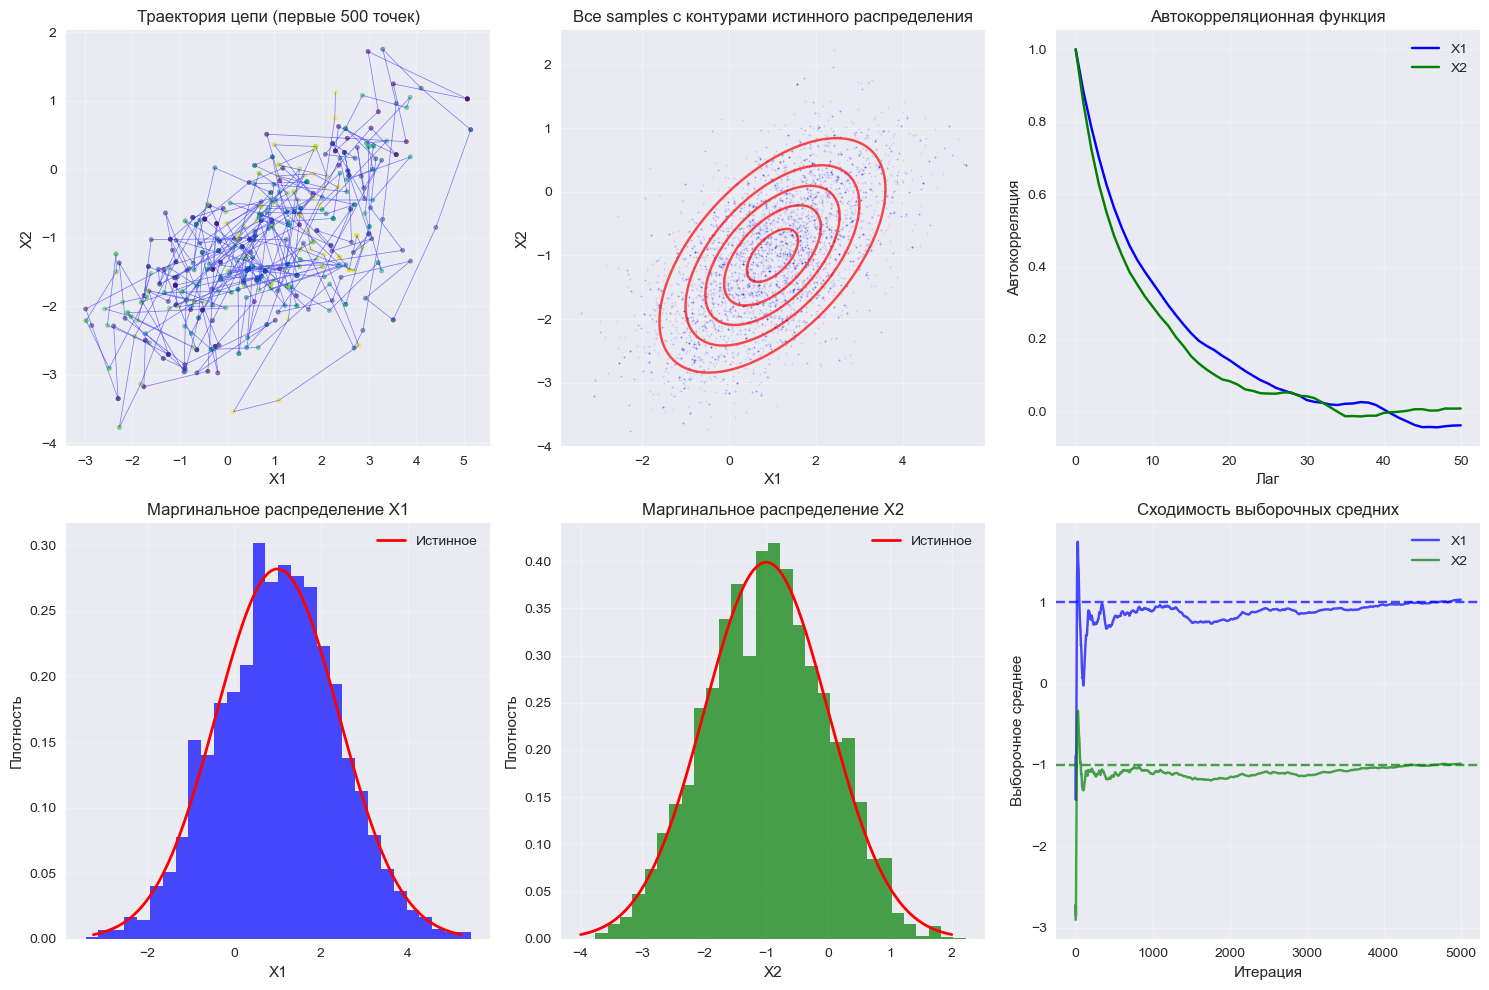

In [7]:
def visualize_multivariate_sampling(samples, true_mu, true_Sigma):
    """
    Визуализация samples из многомерного распределения
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Траектория цепи в 2D
    axes[0, 0].plot(samples[:500, 0], samples[:500, 1], 'b-', alpha=0.5, linewidth=0.5)
    axes[0, 0].scatter(samples[:500, 0], samples[:500, 1], c=range(500), 
                      cmap='viridis', s=10, alpha=0.6)
    axes[0, 0].set_xlabel('X1')
    axes[0, 0].set_ylabel('X2')
    axes[0, 0].set_title('Траектория цепи (первые 500 точек)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Все samples с контурами истинного распределения
    x1_range = np.linspace(true_mu[0]-3*np.sqrt(true_Sigma[0,0]), 
                          true_mu[0]+3*np.sqrt(true_Sigma[0,0]), 100)
    x2_range = np.linspace(true_mu[1]-3*np.sqrt(true_Sigma[1,1]), 
                          true_mu[1]+3*np.sqrt(true_Sigma[1,1]), 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j] = simple_2d_normal([X1[i, j], X2[i, j]], true_mu, true_Sigma)
    
    axes[0, 1].contour(X1, X2, Z, levels=5, colors='red', alpha=0.7)
    axes[0, 1].scatter(samples[:, 0], samples[:, 1], alpha=0.1, s=1, color='blue')
    axes[0, 1].set_xlabel('X1')
    axes[0, 1].set_ylabel('X2')
    axes[0, 1].set_title('Все samples с контурами истинного распределения')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Маргинальное распределение X1
    axes[1, 0].hist(samples[:, 0], bins=30, density=True, alpha=0.7, color='blue')
    x1_pdf = stats.norm.pdf(x1_range, true_mu[0], np.sqrt(true_Sigma[0,0]))
    axes[1, 0].plot(x1_range, x1_pdf, 'r-', linewidth=2, label='Истинное')
    axes[1, 0].set_xlabel('X1')
    axes[1, 0].set_ylabel('Плотность')
    axes[1, 0].set_title('Маргинальное распределение X1')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Маргинальное распределение X2
    axes[1, 1].hist(samples[:, 1], bins=30, density=True, alpha=0.7, color='green')
    x2_pdf = stats.norm.pdf(x2_range, true_mu[1], np.sqrt(true_Sigma[1,1]))
    axes[1, 1].plot(x2_range, x2_pdf, 'r-', linewidth=2, label='Истинное')
    axes[1, 1].set_xlabel('X2')
    axes[1, 1].set_ylabel('Плотность')
    axes[1, 1].set_title('Маргинальное распределение X2')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Автокорреляция
    from statsmodels.tsa.stattools import acf
    autocorr_x1 = acf(samples[:, 0], nlags=50, fft=True)
    autocorr_x2 = acf(samples[:, 1], nlags=50, fft=True)
    
    axes[0, 2].plot(autocorr_x1, 'b-', label='X1')
    axes[0, 2].plot(autocorr_x2, 'g-', label='X2')
    axes[0, 2].set_xlabel('Лаг')
    axes[0, 2].set_ylabel('Автокорреляция')
    axes[0, 2].set_title('Автокорреляционная функция')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 6. Сходимость средних
    running_mean_x1 = np.cumsum(samples[:, 0]) / np.arange(1, len(samples) + 1)
    running_mean_x2 = np.cumsum(samples[:, 1]) / np.arange(1, len(samples) + 1)
    
    axes[1, 2].plot(running_mean_x1, 'b-', label='X1', alpha=0.7)
    axes[1, 2].plot(running_mean_x2, 'g-', label='X2', alpha=0.7)
    axes[1, 2].axhline(y=true_mu[0], color='blue', linestyle='--', alpha=0.7)
    axes[1, 2].axhline(y=true_mu[1], color='green', linestyle='--', alpha=0.7)
    axes[1, 2].set_xlabel('Итерация')
    axes[1, 2].set_ylabel('Выборочное среднее')
    axes[1, 2].set_title('Сходимость выборочных средних')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_multivariate_sampling(samples_2d, mu_true, Sigma_true)